In [173]:
! pip3 show tqdm

Name: tqdm
Version: 4.64.1
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: 
Author-email: 
License: MPLv2.0, MIT Licences
Location: /Users/jon/ml/arena/venv/lib/python3.9/site-packages
Requires: 
Required-by: transformers, huggingface-hub


In [174]:
import os
from typing import Optional, Union
import gym
import gym.envs.registration
import gym.spaces
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

MAIN = __name__ == "__main__"
max_episode_steps = 1000
IS_CI = os.getenv("IS_CI")
N_RUNS = 200 if not IS_CI else 5

In [175]:
ObsType = int
ActType = int

class MultiArmedBandit(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete
    num_arms: int
    stationary: bool
    arm_reward_means: np.ndarray
    arm_star: int

    def __init__(self, num_arms=10, stationary=True):
        super().__init__()
        self.num_arms = num_arms
        self.stationary = stationary
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(num_arms)
        self.reset()

    def step(self, arm: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Note: some documentation references a new style which has (termination, truncation) bools in place of the done bool.
        '''
        assert self.action_space.contains(arm)
        if not self.stationary:
            q_drift = self.np_random.normal(loc=0.0, scale=0.01, size=self.num_arms)
            self.arm_reward_means += q_drift
            self.best_arm = int(np.argmax(self.arm_reward_means))
        reward = self.np_random.normal(loc=self.arm_reward_means[arm], scale=1.0)
        obs = 0
        done = False
        info = dict(best_arm=self.best_arm)
        return (obs, reward, done, info)

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        if self.stationary:
            self.arm_reward_means = self.np_random.normal(loc=0.0, scale=1.0, size=self.num_arms)
        else:
            self.arm_reward_means = np.zeros(shape=[self.num_arms])
        self.best_arm = int(np.argmax(self.arm_reward_means))
        if return_info:
            return (0, dict())
        else:
            return 0

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"
        bandit_samples = []
        for arm in range(self.action_space.n):
            bandit_samples += [np.random.normal(loc=self.arm_reward_means[arm], scale=1.0, size=1000)]
        plt.violinplot(bandit_samples, showmeans=True)
        plt.xlabel("Bandit Arm")
        plt.ylabel("Reward Distribution")
        plt.show()

gym.envs.registration.register(
    id="ArmedBanditTestbed-v0",
    entry_point=MultiArmedBandit,
    max_episode_steps=max_episode_steps,
    nondeterministic=True,
    reward_threshold=1.0,
    kwargs={"num_arms": 10, "stationary": True},
)
if MAIN:
    env = gym.make("ArmedBanditTestbed-v0")
    print("Our env inside its wrappers looks like: ", env)

Our env inside its wrappers looks like:  <TimeLimit<OrderEnforcing<MultiArmedBandit<ArmedBanditTestbed-v0>>>>


/Users/jon/ml/arena/venv/lib/python3.9/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment ArmedBanditTestbed-v0
  logger.warn(f"Overriding environment {id}")


In [176]:
def randint(low, high): # [low, high)
    return np.random.default_rng().integers(low, high)

In [197]:
class Agent:
    '''Base class for agents in a multi-armed bandit environment (you do not need to add any implementation here)'''

    rng: np.random.Generator

    def __init__(self, num_arms: int, seed: int):
        self.num_arms = num_arms
        self.reset(seed)

    def get_action(self) -> ActType:
        raise NotImplementedError()

    def observe(self, action: ActType, reward: float, info: dict) -> None:
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

def run_episode(env: gym.Env, agent: Agent, seed: int):
    (rewards, was_best) = ([], [])
    env.reset(seed=seed)
    agent.reset(seed=seed)
    done = False
    while not done:
        arm = agent.get_action()
        (obs, reward, done, info) = env.step(arm)
        agent.observe(arm, reward, info)
        rewards.append(reward)
        was_best.append(1 if arm == info["best_arm"] else 0)
    rewards = np.array(rewards, dtype=float)
    was_best = np.array(was_best, dtype=int)
    return (rewards, was_best)

def test_agent(env: gym.Env, agent: Agent, n_runs=200, seed=0):
    all_rewards = []
    all_was_bests = []
    rng = np.random.default_rng(seed)
    for n in tqdm(range(n_runs)):
        (rewards, corrects) = run_episode(env, agent, int(rng.integers(0, 10000)))
        all_rewards.append(rewards)
        all_was_bests.append(corrects)
    return (np.array(all_rewards), np.array(all_was_bests))

class RandomAgent(Agent):
    def get_action(self) -> ActType:
        return int(self.rng.integers(0, self.num_arms))


"""
    Implement the RandomAgent subclass which should pick an arm at random.
    This is useful as a baseline to ensure the environment has no bugs. If your later agents are doing worse than random, you have a bug!
    Verify that RandomAgent pulls the optimal arm with frequency roughly 1/num_arms.
    Verify that the average reward is very roughly zero. This is the case since the mean reward for each arm is centered on zero.
"""

if MAIN:
    # def run_episode(env: gym.Env, agent: Agent, seed: int):
    SEED = 41
    env = gym.make("ArmedBanditTestbed-v0")
    randagent = RandomAgent(num_arms=10, seed=SEED)
    print('here')
    (rewards, was_best) = test_agent(env, randagent, n_runs=N_RUNS)
    # print(f'Mean over {N_RUNS} runs: {np.sum(was_best, axis = 1).mean()}')
    print(was_best.mean())


here


100%|██████████| 200/200 [00:00<00:00, 357.11it/s]

0.10041


In [178]:
np.random.default_rng().random()
a = np.zeros(10)
a[:] = 5
a

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

  8%|▊         | 17/200 [00:00<00:01, 166.63it/s]

False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

 32%|███▏      | 64/200 [00:00<00:00, 140.63it/s]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
True
F

 57%|█████▊    | 115/200 [00:00<00:00, 157.10it/s]

True
False
True
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
True
False
False
True
False
False
True
False
Fa

 74%|███████▎  | 147/200 [00:00<00:00, 146.61it/s]

False
False
False
False
False
False
True
False
False
False
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
True
False
False
False
False
False
True
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
True
F

 96%|█████████▌| 192/200 [00:01<00:00, 140.70it/s]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False


100%|██████████| 200/200 [00:01<00:00, 144.63it/s]


False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
F

  7%|▋         | 14/200 [00:00<00:01, 133.49it/s]

False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

 16%|█▌        | 31/200 [00:00<00:01, 151.33it/s]

True
False
True
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
True
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
True
False
F

 24%|██▎       | 47/200 [00:00<00:00, 153.37it/s]

False
False
False
False
False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
Fal

 32%|███▏      | 64/200 [00:00<00:00, 159.71it/s]

False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
True
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
Fals

 40%|████      | 80/200 [00:00<00:00, 149.28it/s]

True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
F

 48%|████▊     | 96/200 [00:00<00:00, 143.58it/s]

False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
True

 56%|█████▌    | 112/200 [00:00<00:00, 145.46it/s]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
Fa

 72%|███████▎  | 145/200 [00:00<00:00, 147.14it/s]

False
True
False
False
False
False
False
True
False
False
False
True
False
False
True
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False


 80%|████████  | 160/200 [00:01<00:00, 142.20it/s]

False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False


 88%|████████▊ | 175/200 [00:01<00:00, 139.70it/s]

False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False

100%|██████████| 200/200 [00:01<00:00, 145.77it/s]


False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False
False
False
False
True
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
True
False
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False


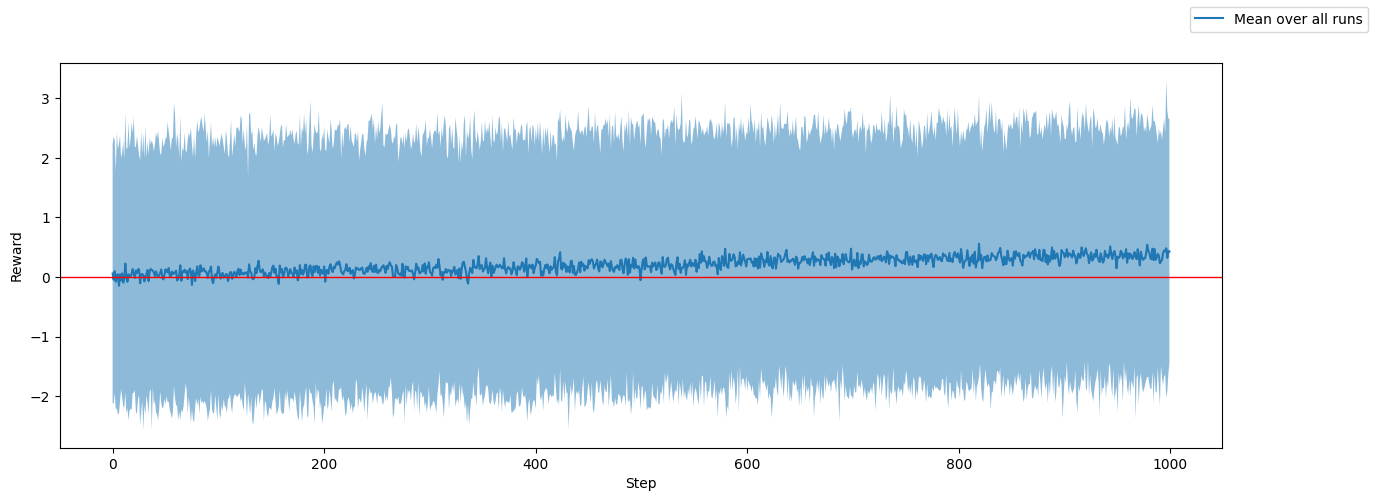

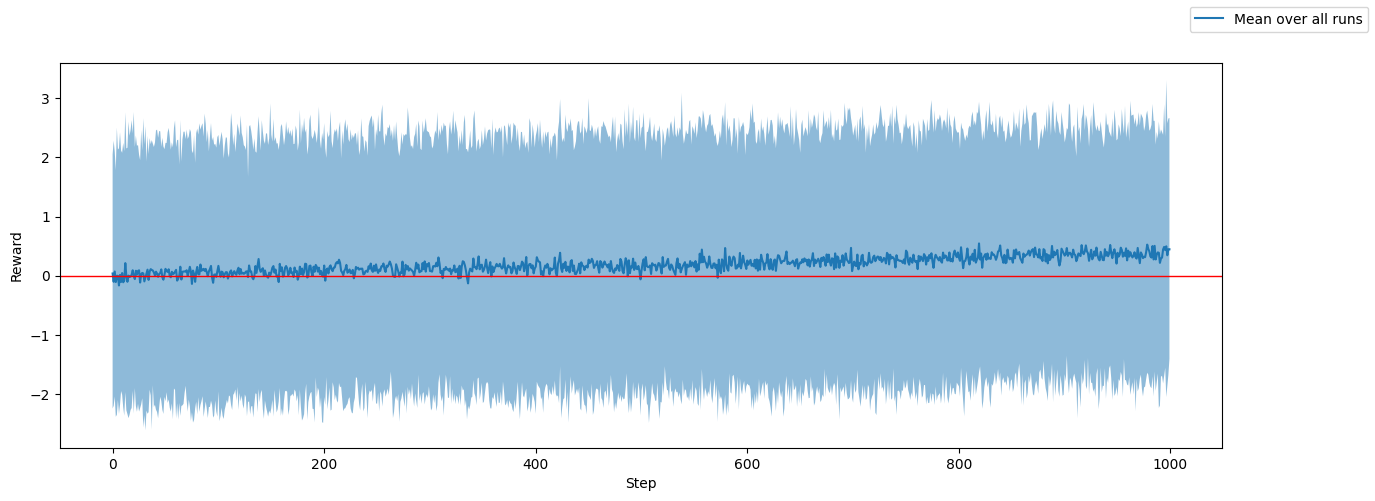

In [213]:
def plot_rewards(all_rewards: np.ndarray):
    (n_runs, n_steps) = all_rewards.shape
    (fig, ax) = plt.subplots(figsize=(15, 5))
    ax.plot(all_rewards.mean(axis=0), label="Mean over all runs")
    quantiles = np.quantile(all_rewards, [0.05, 0.95], axis=0)
    ax.fill_between(range(n_steps), quantiles[0], quantiles[1], alpha=0.5)
    ax.set(xlabel="Step", ylabel="Reward")
    ax.axhline(0, color="red", linewidth=1)
    fig.legend()
    return fig

class RewardAveraging(Agent):
    def __init__(self, num_arms: int, seed: int, epsilon: float, optimism: float):
        super().__init__(num_arms, seed)
        self.estimated_reward = np.zeros(num_arms)
        self.eps = epsilon
        self.optimism = optimism
        self.estimated_reward[:] = optimism
        self.nks = np.zeros(num_arms)
        self.reset(seed)

    def get_action(self):
        r = self.rng.random()
        print(r < self.eps)
        if r < self.eps:
            randint = self.rng.integers(0, self.num_arms)
            print(f'picking randint {randint}')
            return randint
        else:
            print(f'best of {list(map(lambda x: "{:.2f}".format(x),self.estimated_reward.tolist()))} is {self.estimated_reward.argmax()}')
            return np.argmax(self.estimated_reward)

    def observe(self, action, reward, info):
        print(action, reward, info, self.nks[action])
        self.nks[action] += 1
        nk = self.nks[action]
        old_estimate = self.estimated_reward[action]
        updated_reward = old_estimate + (reward - old_estimate) / nk
        self.estimated_reward[action] = updated_reward
        print(f'a: {action} r: {reward} nk:{nk} {old_estimate} -> {updated_reward}, {info}')

    def reset(self, seed: int):
        super().reset(seed)

if MAIN: # 0.23
    num_arms = 10
    stationary = True
    seed = 123412341234
    env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)
    regular_reward_averaging = RewardAveraging(num_arms, seed, epsilon=0.1, optimism=0)
    (all_rewards, all_corrects) = test_agent(env, regular_reward_averaging, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    fig = plot_rewards(all_rewards)
    optimistic_reward_averaging = RewardAveraging(num_arms, seed, epsilon=0.1, optimism=5)
    (all_rewards, all_corrects) = test_agent(env, optimistic_reward_averaging, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    plot_rewards(all_rewards)

In [198]:
class CheatyMcCheater(Agent):
    def __init__(self, num_arms: int, seed: int):
        pass

    def get_action(self):
        pass

    def observe(self, action, reward, info):
        pass

if MAIN:
    num_arms = 10
    cheater = CheatyMcCheater(num_arms, 0)
    env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=False)
    (all_rewards, all_corrects) = test_agent(env, cheater, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    plot_rewards(all_rewards)

  0%|          | 0/200 [00:00<?, ?it/s]


AssertionError: 